In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')

In [32]:
batch_size = 100

In [33]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy().reshape(28, 28), cmap='gray')
    plt.show()

In [34]:
#Load dataset
train = pd.read_csv("fashion-mnist_train.csv")

#normalization and preprocessing
X = train.iloc[:,1:].values / 255.
X = (X-0.5) / 0.5

Y = train.iloc[:,0].values

print(X.shape, Y.shape)

(60000, 784) (60000,)


In [57]:
trn_x, val_x, trn_y, val_y = train_test_split(X, Y, test_size=0.20, random_state=123)

In [59]:
#create torch tensor from numpy array
trn_x_torch = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y_torch = torch.from_numpy(trn_y)

val_x_torch = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y_torch = torch.from_numpy(val_y)

trn = TensorDataset(trn_x_torch, trn_y_torch)
val = TensorDataset(val_x_torch, val_y_torch)

trn_dataloader = torch.utils.data.DataLoader(trn, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

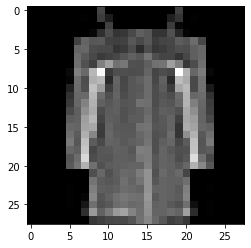

In [24]:
show_torch_image(trn_x_torch[1])

In [39]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.e1 = nn.Linear(28*28, 28)
        self.e2 = nn.Linear(28, 250)
        
        # Latent View
        self.lv = nn.Linear(250, 10)
        
        # Decoder
        self.d1 = nn.Linear(10, 250)
        self.d2 = nn.Linear(250, 500)
        
        self.output_layer = nn.Linear(500, 28*28)
        
    def forward(self,x):
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        
        x = torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        
        x = self.output_layer(x)
        return x

In [40]:
ae = AutoEncoder().to(device)
print(ae)

AutoEncoder(
  (e1): Linear(in_features=784, out_features=28, bias=True)
  (e2): Linear(in_features=28, out_features=250, bias=True)
  (lv): Linear(in_features=250, out_features=10, bias=True)
  (d1): Linear(in_features=10, out_features=250, bias=True)
  (d2): Linear(in_features=250, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=784, bias=True)
)


In [41]:
# define our optimizer and loss function
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [68]:
losses = []
EPOCHS = 10
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn_dataloader):
        data = data.to(device)
    
        optimizer.zero_grad()
        pred = ae(data)
        
        loss = loss_func(pred, data)
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Display
        if batch_idx % 10 == 1:
            print('\rTrain Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(trn_dataloader.dataset),
                batch_size * batch_idx / len(trn_dataloader), 
                loss.cpu().data.item()), 
                end='')
    print('')

Train Epoch: 1/10 [47100/48000 (98%)]	Loss: 0.052040
Train Epoch: 2/10 [47100/48000 (98%)]	Loss: 0.051859
Train Epoch: 3/10 [47100/48000 (98%)]	Loss: 0.051735
Train Epoch: 4/10 [47100/48000 (98%)]	Loss: 0.051610
Train Epoch: 5/10 [47100/48000 (98%)]	Loss: 0.051496
Train Epoch: 6/10 [47100/48000 (98%)]	Loss: 0.051436
Train Epoch: 7/10 [47100/48000 (98%)]	Loss: 0.051282
Train Epoch: 8/10 [47100/48000 (98%)]	Loss: 0.051192
Train Epoch: 9/10 [47100/48000 (98%)]	Loss: 0.051069
Train Epoch: 10/10 [47100/48000 (98%)]	Loss: 0.050992


In [60]:
ae.eval()
predictions = []

for data, target in val_dataloader:
        data = data.to(device)
        pred = ae(data)
        
        for prediction in pred:
            predictions.append(prediction)
               
len(predictions)

12000

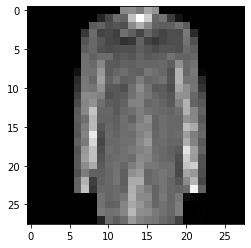

In [66]:
show_torch_image(val_x_torch[1])

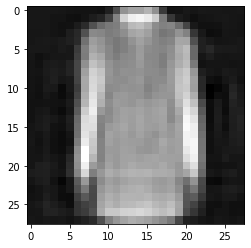

In [67]:
show_torch_image(predictions[1].to('cpu').detach())